## Includings Libraries

In [3]:
import math
import copy
import numpy as np
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

In [6]:
data = pd.read_csv("/content/drive/MyDrive/Free Lance 1.0/stock_returns.csv")
data

,date,stock,return
0,1994-01-03,s_0001,-0.001932
1,1994-01-03,s_0002,0.004001
2,1994-01-03,s_0003,0.001323
3,1994-01-03,s_0004,-0.006785
4,1994-01-03,s_0005,0.004405
...,...,...,...
14101995,2021-12-31,s_1996,0.005466
14101996,2021-12-31,s_1997,-0.056392
14101997,2021-12-31,s_1998,-0.000477
14101998,2021-12-31,s_1999,0.000846


## Splitting Dates

In [7]:
def date_splits(data):

    date = data['date'].values

    year , month , day= [] , [] , []

    for i in range(len(date)):
        temp = date[i].split('-')
        year.append(temp[0])
        month.append(temp[1])
        day.append(temp[2])

    data['day'] = day
    data['month'] = month
    data['year'] = year

    return data

In [8]:
data = date_splits(data)
data

,date,stock,return,day,month,year
0,1994-01-03,s_0001,-0.001932,03,01,1994
1,1994-01-03,s_0002,0.004001,03,01,1994
2,1994-01-03,s_0003,0.001323,03,01,1994
3,1994-01-03,s_0004,-0.006785,03,01,1994
4,1994-01-03,s_0005,0.004405,03,01,1994
...,...,...,...,...,...,...
14101995,2021-12-31,s_1996,0.005466,31,12,2021
14101996,2021-12-31,s_1997,-0.056392,31,12,2021
14101997,2021-12-31,s_1998,-0.000477,31,12,2021
14101998,2021-12-31,s_1999,0.000846,31,12,2021


# 1. Building Monthly & Yearly Portfolios

### 1.A Building Monthly Portfolio

##### 1.A.1 Building Dictionary

In [9]:
# Extracting Unique Values For Setting Up Dictionary Keys
stock = data['stock'].unique()
print(len(stock))

year = data['year'].unique()
print(len(year))

month = data['month'].unique()
print(len(month))

2000
28
12


In [10]:
# Declaring Nested Dictionaries For Easily Iterating Through Data
dicts_month = {}
dicts_year = {}
dicts_stock = {}

for i in range(len(month)):
    dicts_month[month[i]] = copy.deepcopy([])

for i in range(len(year)):
    dicts_year[year[i]] = copy.deepcopy(dicts_month)

for i in range(len(stock)):
    dicts_stock[stock[i]] = copy.deepcopy(dicts_year)

In [11]:
# Assigning Values To Nested Dictionaries
for l in range(len(data)):

    row = data.iloc[[l]]
    x = row["stock"].values
    y = row["year"].values
    z = row["month"].values
    r = row["return"].values

    dicts_stock[x[0]][y[0]][z[0]].append(r[0]) 

    if l % 1000000 == 0:
      print("Data Processed" , l)

Data Processed 0
Data Processed 1000000
Data Processed 2000000
Data Processed 3000000
Data Processed 4000000
Data Processed 5000000
Data Processed 6000000
Data Processed 7000000
Data Processed 8000000
Data Processed 9000000
Data Processed 10000000
Data Processed 11000000
Data Processed 12000000
Data Processed 13000000
Data Processed 14000000


##### 1.A.2 Calculating Volatilities

In [12]:
def volatility_calculator(stock , year, month , dicts_stock):

    temp_stock = []
    temp_year = []
    temp_month = []

    volatilities = []
    for i in stock:

        for j in year:

            for k in month:
                temp_stock.append(i)
                temp_year.append(j)
                temp_month.append(k)

                array = dicts_stock[i][j][k] # Extracting Value

                array = np.array(array)
                mean = np.average(array) # Finding Mean

                N = len(array) - 1
                volatility = 0.0

                for x in array: # Iterating Through All Daily Returns Of A Month
                    temp = x - mean
                    volatility += temp**2

                volatility = volatility/N
                volatility = np.sqrt(volatility)
                volatality = np.std(volatility)
                volatilities.append(volatility) # Saving Volatility Percentage

    return volatilities , temp_stock , temp_year , temp_month

In [13]:
volatilities , temp_stock , temp_year , temp_month = volatility_calculator(stock , year, month , dicts_stock)
print(len(volatilities))

672000


In [14]:
# Volatilities Of All Stocks In Per Month
volatility_dataframe = pd.DataFrame( {"stock" : temp_stock , "year" : temp_year , "month" : temp_month, "volatility":volatilities} )
volatility_dataframe

,stock,year,month,volatility
0,s_0001,1994,01,0.001006
1,s_0001,1994,02,0.000830
2,s_0001,1994,03,0.000987
3,s_0001,1994,04,0.000850
4,s_0001,1994,05,0.000750
...,...,...,...,...
671995,s_2000,2021,08,0.028302
671996,s_2000,2021,09,0.026066
671997,s_2000,2021,10,0.026934
671998,s_2000,2021,11,0.029624


##### 1.A.3 Calculating Percentiles

In [15]:
def percentile_calculator(dataframe):

      # Calculating Percentiles
      breakpoints = [0.1 , 0.3 , 0.5 , 0.7 , 0.9] # Default Percentile Points

      percentiles = []
      # Storing Month & Year
      month = dataframe['month'].unique()
      year = dataframe['year'].unique()

      percentiles.append(dataframe['volatility'].quantile(breakpoints))

      return month , year , percentiles

##### 1.A.4 Making Percentile DataFrame 

In [16]:
def percentile_dataframe_maker(volatility_dataframe):

    # Grouping DataFrame On The Basis Of Portfolio, Year & Month
    grouped_portfolios = volatility_dataframe.groupby(['year','month'])[['stock','year', 'month','volatility']]

    months , years , percentiles = [] , [] , []
    for key, item in grouped_portfolios: # 'grouped_portfolios' Have Multiple DataFrames In It
        temp_month , temp_year , temp_array = percentile_calculator(grouped_portfolios.get_group(key))

        months.append(temp_month)
        years.append(temp_year)
        percentiles.append(temp_array)

    percentile_dataframe = pd.DataFrame()
    percentile_dataframe['month'] = months
    percentile_dataframe['year'] = years
    percentile_dataframe['percentiles'] = percentiles

    return percentile_dataframe

In [17]:
percentile_dataframe = percentile_dataframe_maker(volatility_dataframe)
percentile_dataframe

,month,year,percentiles
0,[01],[1994],"[[0.003328135500528819, 0.011491820081033192, ..."
1,[02],[1994],"[[0.003367209183120811, 0.011205000503603464, ..."
2,[03],[1994],"[[0.0033067185362462446, 0.011447897004526066,..."
3,[04],[1994],"[[0.003361401175786523, 0.011645528845582198, ..."
4,[05],[1994],"[[0.0034475377934378333, 0.011580709551518817,..."
...,...,...,...
331,[08],[2021],"[[0.0033237992680416307, 0.011430679073689588,..."
332,[09],[2021],"[[0.0033114426377799985, 0.011696680964189689,..."
333,[10],[2021],"[[0.0033399408614957125, 0.011629350971694374,..."
334,[11],[2021],"[[0.003353510432497173, 0.011526073183828154, ..."


##### 1.A.5 Allocating Portfolios

In [18]:
def portfolio_allocator(volatility_dataframe , percentile_dataframe):

    portfolio = []

    for i in range(len(volatility_dataframe)):

        temp_month = volatility_dataframe['month'][i]
        temp_year = volatility_dataframe['year'][i]
        temp_volatility = volatility_dataframe['volatility'][i]
        
        result = percentile_dataframe.loc[(percentile_dataframe['month'] == temp_month) & (percentile_dataframe['year'] == temp_year)]
        percentiles = result['percentiles'] 

        list_of_percentiles = []
        for k in percentiles:
            list_of_percentiles.append(k[0].values)


        # Assigning Portfolios On The Basis Of Volatilities
        if temp_volatility < list_of_percentiles[0][0]:
            portfolio.append('pf_01')
        elif temp_volatility > list_of_percentiles[0][0] and temp_volatility <= list_of_percentiles[0][1]:
            portfolio.append('pf_02')
        elif temp_volatility > list_of_percentiles[0][1] and temp_volatility <= list_of_percentiles[0][2]:
            portfolio.append('pf_03')
        elif temp_volatility > list_of_percentiles[0][2] and temp_volatility <= list_of_percentiles[0][3]:
            portfolio.append('pf_04')
        elif temp_volatility > list_of_percentiles[0][3] and temp_volatility <= list_of_percentiles[0][4]:
            portfolio.append('pf_05')
        elif temp_volatility > list_of_percentiles[0][4]:
            portfolio.append('pf_06')

    return portfolio

In [19]:
portfolio = portfolio_allocator(volatility_dataframe , percentile_dataframe)
print(len(portfolio))

672000


##### 1.A.6 Building Portfolio DataFrame

In [20]:
def portfolio_dataframe_maker(stock , year , month, dicts_stock, volatilities, portfolio):

    # Saving Values For DataFrame
    stocks , years , months , month_points = [] , [] , [] , []

    for i in stock:

        for j in year:

            for k in month:

                    stocks.append(i)
                    years.append(j)
                    months.append(k)

                    month_points.append(dicts_stock[i][j][k])

    portfolios_collecion = pd.DataFrame()

    # Assigning Values To Monthly Portfolio DataFrame
    portfolios_collecion['stocks'] = stocks
    portfolios_collecion['years'] = years
    portfolios_collecion['months'] = months

    portfolios_collecion['volatilities'] = volatilities
    portfolios_collecion['portfolio'] = portfolio
    portfolios_collecion['daily returns'] = month_points

    return portfolios_collecion

In [21]:
portfolios_collecion = portfolio_dataframe_maker(stock , year , month, dicts_stock, volatilities, portfolio)
portfolios_collecion

,stocks,years,months,volatilities,portfolio,daily returns
0,s_0001,1994,01,0.001006,pf_01,"[-0.0019317255613472, -0.0021507742168536, -0...."
1,s_0001,1994,02,0.000830,pf_01,"[-0.0027142762025819, -0.0010522639160586, -0...."
2,s_0001,1994,03,0.000987,pf_01,"[-0.0025941251242849, -0.0020724719128216, -0...."
3,s_0001,1994,04,0.000850,pf_01,"[-0.0005498631410026, -0.002190558421261, -0.0..."
4,s_0001,1994,05,0.000750,pf_01,"[-0.000283393382858, -0.0021169690321606, -0.0..."
...,...,...,...,...,...,...
671995,s_2000,2021,08,0.028302,pf_04,"[0.0069456420910846, -0.0304413496939278, 0.01..."
671996,s_2000,2021,09,0.026066,pf_04,"[-0.0141312910001873, -0.0281453808360912, 0.0..."
671997,s_2000,2021,10,0.026934,pf_04,"[0.0488992601478248, -0.0105090691250504, 0.00..."
671998,s_2000,2021,11,0.029624,pf_04,"[-0.0015478949044375, 0.0331959867345135, -0.0..."


### 1.B Monthly Returns Of Portfolio

##### 1.B.1 Monthly Returns


In [22]:
# Calculating Monthly Returns
monthly_returns = []

for i in range(len(portfolios_collecion["daily returns"])):

    temp = 1.0
    for x in portfolios_collecion["daily returns"][i]:
        x += 1.0
        temp *= x

    temp -= 1.0
    monthly_returns.append(temp * 100)

portfolios_collecion["Monthly Returns"] = monthly_returns

##### 1.B.2 Grouping Portfolios

In [23]:
# Grouping DataFrame On The Basis Of Portfolio, Year & Month
grouped_portfolios = portfolios_collecion.groupby(['portfolio','years','months'])[['portfolio','stocks', 'years','months','volatilities',"Monthly Returns"]]

# Printing All Portfolios
for key, item in grouped_portfolios: # 'grouped_portfolios' Have Multiple DataFrames In It

    print(grouped_portfolios.get_group(key).sort_values("volatilities"), "\n\n")

Streaming output truncated to the last 5000 lines.
224807     pf_06  s_0670  1995     12      0.107870       -16.038477
297383     pf_06  s_0886  1995     12      0.108907         3.513849
485543     pf_06  s_1446  1995     12      0.138950       -65.270845
451943     pf_06  s_1346  1995     12      0.147959        16.907984

[200 rows x 6 columns] 


       portfolio  stocks years months  volatilities  Monthly Returns
63864      pf_06  s_0191  1996     01      0.056508       -53.999680
86712      pf_06  s_0259  1996     01      0.056523         3.982859
486552     pf_06  s_1449  1996     01      0.056605       -42.588404
291336     pf_06  s_0868  1996     01      0.056751         5.082883
549048     pf_06  s_1635  1996     01      0.056770       132.883620
...          ...     ...   ...    ...           ...              ...
224808     pf_06  s_0670  1996     01      0.114703        15.477764
485544     pf_06  s_1446  1996     01      0.118694       -55.436302
606840     pf_06  s_1807 

##### 1.B.3 Making Time Series DataFrame

In [26]:
portfolios_list = []
dates = []
monthly_return = []

for key, item in grouped_portfolios:

    one_month_portfolio = grouped_portfolios.get_group(key).sort_values("volatilities")

    returns = one_month_portfolio["Monthly Returns"].values
    returns = np.average(returns)

  # Extracting Year Of Portfolio
    year = "" 
    for i in one_month_portfolio["years"]:
        year = i
        break

  # Extracting Month Of Portfolio
    month = ""
    for i in one_month_portfolio["months"]:
        month = i
        break

  # Appending To Create Date
    date = year + "-" + month

  # Extracting Name Of Portfolio
    portfolio_name = ""
    for i in one_month_portfolio["portfolio"]:
        portfolio_name = i
        break

    portfolios_list.append(returns)
    dates.append(date)

    monthly_return.append(portfolio_name)

In [29]:
time_series = pd.DataFrame( {"Date" : dates , "Monthly Returns" : portfolios_list , "Portfolio" : monthly_return} )
time_series

,Date,Monthly Returns,Portfolio
0,1994-01,0.738471,pf_01
1,1994-02,0.367750,pf_01
2,1994-03,1.399301,pf_01
3,1994-04,0.949285,pf_01
4,1994-05,0.854047,pf_01
...,...,...,...
2011,2021-08,7.150506,pf_06
2012,2021-09,11.493776,pf_06
2013,2021-10,6.845161,pf_06
2014,2021-11,1.001186,pf_06


# Answers To Questions

##### A) Work Distribution: 

##### B) The daily returns of s_328 and s_1583 on the lasttrading date of Apr and Dec 2020

In [30]:
array = dicts_stock['s_0328']['2020']['12']
print("The Daily Return of Stock 's_328' on Last Trading Day of December 2020 : ",array[-1])

The Daily Return of Stock 's_328' on Last Trading Day of December 2020 :  -0.0336067938293886


In [31]:
array = dicts_stock['s_0328']['2020']['04']
print("The Daily Return of Stock 's_328' on Last Trading Day of April 2020 : ",array[-1])

The Daily Return of Stock 's_328' on Last Trading Day of April 2020 :  -0.0003763044169538


In [32]:
array = dicts_stock['s_1583']['2020']['12']
print("The Daily Return of Stock 's_1583' on Last Trading Day of December 2020 : ",array[-1])

The Daily Return of Stock 's_1583' on Last Trading Day of December 2020 :  0.017312621647525


In [33]:
array = dicts_stock['s_1583']['2020']['04']
print("The Daily Return of Stock 's_1583' on Last Trading Day of Apri 2020 : ",array[-1])

The Daily Return of Stock 's_1583' on Last Trading Day of Apri 2020 :  0.0263269207850058


##### C) The volatilities and monthly returns of s_0005, s_1000, s_1875 and s_2000 in Mar, Jun, Sep, and Dec 2019.

In [35]:
stock_names = ["s_0005" , "s_1000" , "s_1875" , "s_2000"]
stock_names = np.array(stock_names)

days = ["03" , "06" , "09" , "12"]
days = np.array(days)

for key, item in grouped_portfolios:
    one_month_portfolio = grouped_portfolios.get_group(key).sort_values("volatilities")

    for i in (one_month_portfolio["years"]):
        if(i == "2019"): # Shortlisting Those with Year 2019

            for j in stock_names:
                shortlisted = one_month_portfolio. loc[one_month_portfolio['stocks'] == j]  # Shortlisting Those with Stock Name In 'stock_names' Array

                for k in days:
                    temp = shortlisted.loc[one_month_portfolio['months'] == k] # Shortlisting Those with Month Name In 'days' Array
                    value = temp.index

                    if (len(value) != 0 ): # If Array Not Empty

                        result = shortlisted.loc[one_month_portfolio['months'] == k]

                        v = result['volatilities'].values
                        m = result['Monthly Returns'].values 

                        print('Volatility & Monthly Returns Of '+ j +' In '+ k + ' 2019 : ' , "{:.4f}".format(v[0])  , "{:.4f}".format(m[0]) )
        break      


Volatility & Monthly Returns Of s_1875 In 03 2019 :  0.0011 0.3574
Volatility & Monthly Returns Of s_1875 In 06 2019 :  0.0012 -0.5546
Volatility & Monthly Returns Of s_1875 In 09 2019 :  0.0014 -1.3166
Volatility & Monthly Returns Of s_1875 In 12 2019 :  0.0009 -0.8471
Volatility & Monthly Returns Of s_0005 In 06 2019 :  0.0193 -17.5028
Volatility & Monthly Returns Of s_2000 In 12 2019 :  0.0196 -24.0860
Volatility & Monthly Returns Of s_0005 In 03 2019 :  0.0331 -17.1114
Volatility & Monthly Returns Of s_2000 In 03 2019 :  0.0230 -13.9780
Volatility & Monthly Returns Of s_2000 In 06 2019 :  0.0289 -20.9555
Volatility & Monthly Returns Of s_0005 In 09 2019 :  0.0302 -9.0598
Volatility & Monthly Returns Of s_2000 In 09 2019 :  0.0209 -21.3471
Volatility & Monthly Returns Of s_1000 In 03 2019 :  0.0469 -45.2580
Volatility & Monthly Returns Of s_1000 In 06 2019 :  0.0365 -35.2522
Volatility & Monthly Returns Of s_1000 In 09 2019 :  0.0544 -41.8989
Volatility & Monthly Returns Of s_0005 I

##### D) The portfolio allocation of stocks s_0123, s_0582, s_1409 and s_1990 in Apr and Oct 2005. 


In [36]:
stock_names = ["s_0123", "s_0582", "s_1409" ,"s_1990"]
stock_names = np.array(stock_names)

days = ["04" , "10"]
days = np.array(days)

for key, item in grouped_portfolios:
    one_month_portfolio = grouped_portfolios.get_group(key).sort_values("volatilities")

    for i in one_month_portfolio["years"]:
        if(i == "2005"):  # Shortlisting Those with Year 2005

            for j in stock_names:
                shortlisted = one_month_portfolio. loc[one_month_portfolio['stocks'] == j] # Shortlisting Those with Stock Name In 'stock_names' Array

                for k in days:
                    temp = shortlisted.loc[one_month_portfolio['months'] == k]  # Shortlisting Those with Month Name In 'days' Array
                    value = temp.index

                    if(len(value) != 0): # If Array Not Empty

                        result = shortlisted.loc[one_month_portfolio['months'] == k]

                        v = result['portfolio'].values
                        
                        print('Portfolio Of '+ j +' In '+ k + ' 2005 : ' , v[0] )
        break      


Portfolio Of s_1990 In 04 2005 :  pf_02
Portfolio Of s_1990 In 10 2005 :  pf_02
Portfolio Of s_0123 In 04 2005 :  pf_04
Portfolio Of s_1409 In 04 2005 :  pf_04
Portfolio Of s_0123 In 10 2005 :  pf_04
Portfolio Of s_1409 In 10 2005 :  pf_04
Portfolio Of s_0582 In 04 2005 :  pf_05
Portfolio Of s_0582 In 10 2005 :  pf_05


##### E) The date (in YYMM format) where the highest realized monthly returns is observed for all the portfolios.

In [37]:
returns = []
year_months = []
portfolio_names = []

for key, item in grouped_portfolios:

    one_month_portfolio = grouped_portfolios.get_group(key).sort_values("volatilities")
    values = one_month_portfolio["Monthly Returns"].values

    if( len(values) != 0 ):

        value = max(values) # Shortlisting Max Values
        result = one_month_portfolio.loc[one_month_portfolio['Monthly Returns'] == value]

        m = result['months'].values
        p = result['portfolio'].values
        y = result['years'].values

        # Appending Dates
        m = m[0]
        y = y[0]
        d = y + "-" + m

        returns.append(value)
        year_months.append(d)
        portfolio_names.append(p[0])

In [42]:
highest_returns = pd.DataFrame( {"Date" : year_months , "Portfolio" : portfolio_names , "Monthly Return" : returns} )
highest_returns

,Date,Portfolio,Monthly Return
0,1994-01,pf_01,51.930608
1,1994-02,pf_01,47.849582
2,1994-03,pf_01,59.755398
3,1994-04,pf_01,46.890615
4,1994-05,pf_01,54.345311
...,...,...,...
2011,2021-08,pf_06,211.713295
2012,2021-09,pf_06,260.827775
2013,2021-10,pf_06,224.596415
2014,2021-11,pf_06,145.793216


In [43]:
grouped_portfolios = highest_returns.groupby(['Portfolio'])[["Date",'Portfolio',"Monthly Return"]]

for key, item in grouped_portfolios:

    result = grouped_portfolios.get_group(key).sort_values("Monthly Return")
    print(result.tail(1))

        Date Portfolio  Monthly Return
237  2013-10     pf_01       62.907075
        Date Portfolio  Monthly Return
352  1995-05     pf_02       97.999325
        Date Portfolio  Monthly Return
705  1996-10     pf_03      137.764225
         Date Portfolio  Monthly Return
1269  2015-10     pf_04      203.291402
         Date Portfolio  Monthly Return
1495  2006-08     pf_05      306.259407
         Date Portfolio  Monthly Return
1770  2001-07     pf_06      709.292576


##### F) The annualized return and volatility of all portfolios presented in 2 decimal points for th entire analysis period

In [44]:
for i in range(len(time_series["Date"])):

    d = time_series["Date"][i]
    d = d.split("-")
    time_series["Date"][i] = d[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [73]:
volatilities = []
years = []
portfolios = []
yearly_returns = []

grouped_portfolio = time_series.groupby(['Date','Portfolio'])[['Date','Portfolio', 'Monthly Returns']]

for key, item in grouped_portfolio:

    one_portfolio = grouped_portfolio.get_group(key).sort_values("Monthly Returns")
    returns = one_portfolio["Monthly Returns"].values

    # Default Parameters For Calculating Volatility
    N = len(returns)
    average = np.average(returns)
    volatility = 0.0

    # Calculating Volatilities
    for x in returns:
        subtract = x - average
        volatility += subtract**2

    volatility = (volatility / (N-1))
    volatility = math.sqrt(volatility)

    volatility *= 100 # For Percentage 
    volatility *= 12  # For Annual 

    volatility = math.sqrt(volatility)
    volatilities.append("{:.2f}".format(volatility))

    # Calculating Yearly Return
    temp = 0.0
    yearly_return = 1.0

    dates = one_portfolio["Date"].values
    portfolio_names = one_portfolio["Portfolio"].values

    for i in returns:
        temp = 1 + i
        temp = (temp**(1/N))
        yearly_return *= temp

    years.append(dates[0])
    portfolios.append(portfolio_names[0])

    yearly_return -= 1
    yearly_return = yearly_return * 12
    yearly_returns.append("{:.2f}".format(yearly_return))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


In [74]:
#  annualized returns and volatilities of all portfolios for entire analysis period
annual_report = pd.DataFrame({"Year" : years , "Portfolio" : portfolios , "Yearly Return %" : yearly_returns , "Volatility %" : volatilities})
a=copy.deepcopy(annual_report.loc[annual_report["Portfolio"]=="pf_06"])
aa=a["Yearly Return %"].values
next=[]
for i in aa:
    if(i!="nan"):
        next.append(float(i))
next=np.array(next)
af=np.average(next)
annual_report

,Year,Portfolio,Yearly Return %,Volatility %
0,1994,pf_01,9.32,20.56
1,1994,pf_02,7.69,21.55
2,1994,pf_03,12.55,25.15
3,1994,pf_04,18.19,36.62
4,1994,pf_05,45.72,40.96
...,...,...,...,...
163,2021,pf_02,9.37,21.96
164,2021,pf_03,11.41,25.53
165,2021,pf_04,19.35,30.18
166,2021,pf_05,47.59,36.47


# Analysis (Appendix B)

In [68]:
returns_pf01 , volatilities_pf01 , length_pf01 = 0 , 0 , 0
returns_pf02 , volatilities_pf02 , length_pf02 = 0 , 0 , 0 
returns_pf03 , volatilities_pf03 , length_pf03 = 0 , 0 , 0 
returns_pf04 , volatilities_pf04 , length_pf04 = 0 , 0 , 0 
returns_pf05 , volatilities_pf05 , length_pf05 = 0 , 0 , 0 
returns_pf06 , volatilities_pf06 , length_pf06 = 0 , 0 , 0 

for i in range(len(annual_report)):
  
  if annual_report['Portfolio'][i] == 'pf_01': # Returns And Volatility Average For Portfolio 1, Squaring Because Of Negative Values
      returns_pf01 += abs(float(annual_report['Yearly Return %'][i]))
      volatilities_pf01 += abs(float(annual_report['Volatility %'][i]))

      length_pf01 += 1

  elif annual_report['Portfolio'][i] == 'pf_02': # Returns And Volatility Average For Portfolio 2, Squaring Because Of Negative Values
      returns_pf02 += abs(float(annual_report['Yearly Return %'][i]))
      volatilities_pf02 += abs(float(annual_report['Volatility %'][i]))

      length_pf02 += 1

  elif annual_report['Portfolio'][i] == 'pf_03': # Returns And Volatility Average For Portfolio 3, Squaring Because Of Negative Values
      returns_pf03 += abs(float(annual_report['Yearly Return %'][i]))
      volatilities_pf03 += float(annual_report['Volatility %'][i])

      length_pf03 += 1

  elif annual_report['Portfolio'][i] == 'pf_04': # Returns And Volatility Average For Portfolio 4, Squaring Because Of Negative Values
      returns_pf04 += abs(float(annual_report['Yearly Return %'][i]))
      volatilities_pf04 += float(annual_report['Volatility %'][i])

      length_pf04 += 1

  elif annual_report['Portfolio'][i] == 'pf_05': # Returns And Volatility Average For Portfolio 5, Squaring Because Of Negative Values
      returns_pf05 += abs(float(annual_report['Yearly Return %'][i]))
      volatilities_pf05 += float(annual_report['Volatility %'][i])

      length_pf05 += 1

  elif annual_report['Portfolio'][i] == 'pf_06': # Returns And Volatility Average For Portfolio 6, Squaring Because Of Negative Values
        if(annual_report['Yearly Return %'][i]=="nan"):
            returns_pf06+=af
        else:
            returns_pf06 += abs(float(annual_report['Yearly Return %'][i]))
        volatilities_pf06 += float(annual_report['Volatility %'][i])

        length_pf06 += 1

In [69]:
# Calculating Averages & Making Arrays
returns = []
volatilities = []

if(length_pf01 != 0):
  returns.append(returns_pf01/length_pf01)
  volatilities.append(volatilities_pf01/length_pf01)
else:
  returns.append(0)
  volatilities.append(0)

if(length_pf02 != 0):
  returns.append(returns_pf02/length_pf02)
  volatilities.append(volatilities_pf02/length_pf02)
else:
  returns.append(0)
  volatilities.append(0)

if(length_pf03 != 0):
  returns.append(returns_pf03/length_pf03)
  volatilities.append(volatilities_pf03/length_pf03)
else:
  returns.append(0)
  volatilities.append(0)

if(length_pf04 != 0):
  returns.append(returns_pf04/length_pf04)
  volatilities.append(volatilities_pf04/length_pf04)
else:
  returns.append(0)
  volatilities.append(0)

if(length_pf05 != 0):
  returns.append(returns_pf05/length_pf05)
  volatilities.append(volatilities_pf05/length_pf05)
else:
  returns.append(0)
  volatilities.append(0)

if(length_pf06 != 0):
  returns.append(returns_pf06/length_pf06)
  volatilities.append(volatilities_pf06/length_pf06)
else:
  returns.append(0)
  volatilities.append(0)

In [70]:
print(returns)
print(volatilities)

[8.918214285714285, 8.839285714285714, 11.1375, 18.111428571428572, 46.12214285714286, 56.56692307692307]
[16.48964285714286, 20.316071428571433, 27.146428571428565, 34.714999999999996, 40.24464285714286, 56.85428571428571]


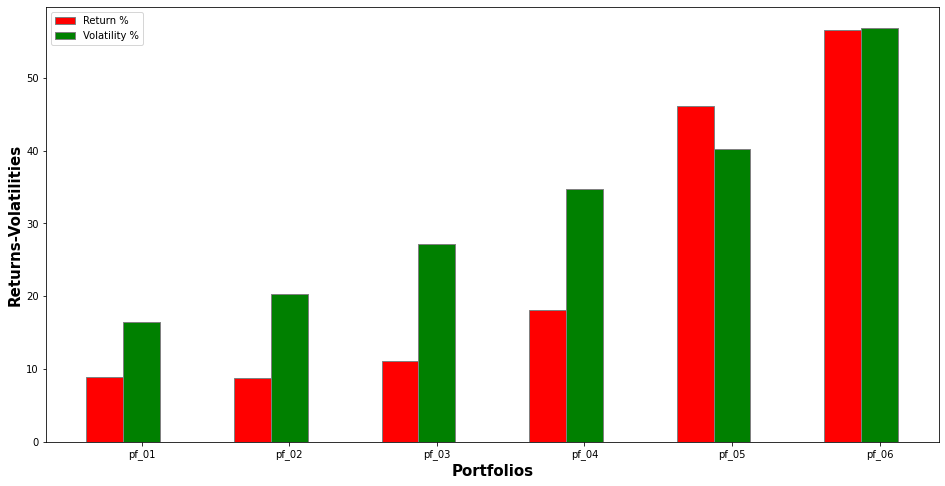

In [71]:
import matplotlib.pyplot as plt

barWidth = 0.25
fig = plt.subplots(figsize =(16, 8))

bar1 = np.arange(len(returns))
bar2 = [x + barWidth for x in bar1]

plt.bar(bar1, returns, color ='r', width = barWidth,
        edgecolor ='grey', label ='Return %')
plt.bar(bar2, volatilities, color ='g', width = barWidth,
        edgecolor ='grey', label ='Volatility %')

plt.xlabel('Portfolios', fontweight ='bold', fontsize = 15)
plt.ylabel('Returns-Volatilities', fontweight ='bold', fontsize = 15)

plt.xticks([r + barWidth for r in range(len(returns))],
        ['pf_01', 'pf_02', 'pf_03', 'pf_04', 'pf_05','pf_06'])

plt.legend()
plt.show()

## Final Observation:

Red bar represents the return percentage of a portfolio whereas green bar represents its volatility. As we know that higher volatility means higher risk. So for the first four portfolios all investments have greater risks but lower returns. But for portfolio 5 and 6, its different as risk is high but returns are also much higher than low risk portfolios. So it can be stated that risky investments do have higher realised returns in the market.
